In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

df = pd.read_csv('../data/bank-full.csv', sep=';')
df = df[['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']]

numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

y = df.y.map({'no': 0, 'yes': 1}).astype(int)
X = df.drop('y', axis=1)
dict_vectorizer = DictVectorizer(sparse=False)

def get_splitted_df():
    df_train_full, df_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    df_train, df_val, y_train, y_val = train_test_split(df_train_full, y_train_full, test_size=len(X) * 0.2 / len(df_train_full), random_state=1)
    
    return df_train_full, df_train, df_val, df_test, y_train_full, y_train, y_val, y_test

def get_trained_model(train_serie: pd.Series, y_train: pd.Series, reg: float = 1.0):
    train_serie_dict = train_serie.to_dict(orient='records')
    X_train = dict_vectorizer.fit_transform(train_serie_dict)
    
    model = LogisticRegression(solver='liblinear', C=reg, max_iter=1000)
    model.fit(X_train, y_train)
    
    return model

def predict_model(tmp_model, serie: pd.DataFrame):    
    serie_dict = serie.to_dict(orient='records')
    X_serie = dict_vectorizer.fit_transform(serie_dict)

    y_predict = tmp_model.predict_proba(X_serie)[:, 1]
    
    return y_predict

df_train_full, df_train, df_val, df_test, y_train_full, y_train, y_val, y_test = get_splitted_df()

model = get_trained_model(df_train, y_train)

### Question 1

In [28]:
aucs = {}
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    
    aucs[col] = auc
    
aucs = dict(sorted(aucs.items(), key=lambda item: item[1], reverse=True))
aucs


{'duration': 0.8146942424632446,
 'previous': 0.5985621197852585,
 'pdays': 0.5901240684387066,
 'balance': 0.588819759177242,
 'campaign': 0.5714526215503108,
 'day': 0.5259654358875353,
 'age': 0.5121718893992577}

### Qurestion 2

In [34]:
y_predict = predict_model(model, df_val)
y_val_pred = (y_predict > 0.5).astype(int)

auc = roc_auc_score(y_val, y_val_pred)
round(auc, 3)


0.652

### Question 3

/var/folders/x9/t16jfwq91z735wm10ntxvh780000gq/T/ipykernel_2372/2433494807.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_prec_recall = pd.concat([df_prec_recall, df_temp], ignore_index=True)


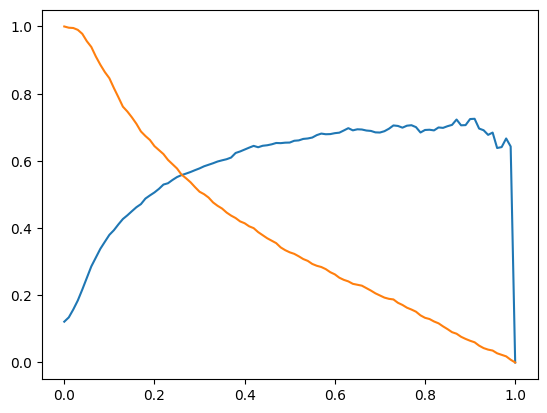

In [42]:
df_prec_recall = pd.DataFrame(columns={'threshold': [], 'precision': [], 'recall': []}) 

def get_precision_recall(y_predict, y_val, threshold):
    y_val_pred = (y_predict > threshold).astype(int)

    real_positive = (y_val == 1)
    real_negative = (y_val == 0)

    predicted_positive = (y_val_pred == 1)
    predicted_negative = (y_val_pred == 0)

    tp = (real_positive & predicted_positive).sum()
    tn = (real_negative & predicted_negative).sum()
    fp = (real_negative & predicted_positive).sum()
    fn = (real_positive & predicted_negative).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

for threshold in np.linspace(0, 1, 101):
    precision, recall, f1_score = get_precision_recall(y_predict, y_val, threshold)
    
    df_temp = pd.DataFrame({'threshold': [threshold], 'precision': [precision], 'recall': [recall]})
    df_prec_recall = pd.concat([df_prec_recall, df_temp], ignore_index=True)

plt.plot(df_prec_recall.threshold, df_prec_recall.precision, label='precision')
plt.plot(df_prec_recall.threshold, df_prec_recall.recall, label='recall')


### Question 4

In [53]:
f1_scores = {}

for threshold in np.linspace(0, 1, 101):
    precision, recall, f1_score = get_precision_recall(y_predict, y_val, threshold)
    f1_scores[threshold] = f1_score
    
f1_scores = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))
f1_scores

{0.22: 0.5713087248322147,
 0.21: 0.5686194182712003,
 0.19: 0.56796875,
 0.2: 0.5667334669338677,
 0.23: 0.5660538691748611,
 0.18: 0.5659655831739961,
 0.24: 0.5656918376254911,
 0.25: 0.5643079661771252,
 0.16: 0.5599425699928213,
 0.17: 0.5592592592592592,
 0.26: 0.5584356525693497,
 0.15: 0.5568300312825859,
 0.27: 0.5550945136007377,
 0.14: 0.5521885521885522,
 0.28: 0.5512400561534863,
 0.13: 0.5471204188481675,
 0.29: 0.5459742734635541,
 0.3: 0.5406976744186046,
 0.12: 0.5405236907730673,
 0.31: 0.5392156862745098,
 0.32: 0.5352532274081429,
 0.11: 0.5312407462244596,
 0.33: 0.5282828282828282,
 0.1: 0.5242663656884876,
 0.34: 0.5240532241555783,
 0.35000000000000003: 0.5201654601861426,
 0.36: 0.5136268343815513,
 0.37: 0.5092838196286472,
 0.38: 0.5088948787061995,
 0.09: 0.5074866310160429,
 0.39: 0.5032751091703056,
 0.4: 0.501101321585903,
 0.41000000000000003: 0.49609810479375704,
 0.42: 0.49353569421023047,
 0.08: 0.4896829391041772,
 0.43: 0.48326715825297784,
 0.44: 0

### Question 5

In [67]:
def get_auc_scores(C: float = 1.0):
    auc_scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]
        
        y_train = y_train_full.iloc[train_idx]
        y_val = y_train_full.iloc[val_idx]
        
        model = get_trained_model(df_train, y_train, C)
        y_predict = predict_model(model, df_val)
        
        auc = roc_auc_score(y_val, y_predict)
        auc_scores.append(round(auc, 3))
    
    std_scores = round(np.std(auc_scores),3)
    mean_scores = round(np.mean(auc_scores), 3)
    print(f'std: {std_scores} - mean: {mean_scores} - C: {C}')
    
    return std_scores, mean_scores, C

get_auc_scores()


std: 0.005 - mean: 0.906 - C: 1.0


(0.005, 0.906, 1.0)

### Question 6

In [68]:
for C in [0.000001, 0.001, 1]:
    get_auc_scores(C)

std: 0.009 - mean: 0.702 - C: 1e-06
std: 0.007 - mean: 0.861 - C: 0.001
std: 0.005 - mean: 0.906 - C: 1
